In [1]:
!pip install datasets==3.0.2 faiss-gpu numpy==1.25.0 torch==2.0.0 transformers==4.45.2 sentence_transformers

In [2]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer
import torch
import faiss
import numpy as np

In [3]:
# Załadowanie zbioru danych SQuAD z HuggingFace
dataset = load_dataset("sentence-transformers/squad")
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87599
    })
})

In [4]:
dataset["train"]

Dataset({
    features: ['question', 'answer'],
    num_rows: 87599
})

In [ ]:
# Usunięcie duplikatów z kolumny 'question'
unique_questions = list(set(dataset["train"]["question"]))

# Usunięcie duplikatów z kolumny 'answer'
unique_answers = list(set(dataset["train"]["answer"]))

len(unique_questions), len(unique_answers)

(87341, 18891)

In [6]:
model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")

In [7]:
device = torch.device("cuda")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:
# Tworzenie osadzeń dla kolumny 'answer' (dokumenty)
# Osadzenia będą używane do porównywania z zapytaniami
answer_embeddings = model.encode(
    unique_answers, batch_size=32, convert_to_tensor=True, show_progress_bar=True
)

Batches:   0%|          | 0/591 [00:00<?, ?it/s]

In [ ]:
# Tworzenie osadzeń dla kolumny 'question' (zapytania)
question_embeddings = model.encode(
    unique_questions, batch_size=32, convert_to_tensor=True, show_progress_bar=True
)

Batches:   0%|          | 0/2730 [00:00<?, ?it/s]

In [10]:
question_embeddings = question_embeddings.to("cuda")
answer_embeddings = answer_embeddings.to("cuda")

In [11]:
question_embeddings = util.normalize_embeddings(question_embeddings)
answer_embeddings = util.normalize_embeddings(answer_embeddings)

In [ ]:
# zapisz do pickle
# import pickle
#
# with open("question_embeddings.pkl", "wb") as f:
#    pickle.dump(question_embeddings, f)
#
# with open("answer_embeddings.pkl", "wb") as f:
#    pickle.dump(answer_embeddings, f)
#
# with open("model.pkl", "wb") as f:
#    pickle.dump(model, f)

In [43]:
# załaduj pickle
import pickle

with open("question_embeddings.pkl", "rb") as f:
    question_embeddings = pickle.load(f)

with open("answer_embeddings.pkl", "rb") as f:
    answer_embeddings = pickle.load(f)

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
def find_similar_sentences(
    question_embeddings,
    answer_embeddings,
    unique_questions,
    unique_answers,
    model,
    top_k=5,
    n_print=5,
):
    results = {}

    hits = util.semantic_search(
        question_embeddings,
        answer_embeddings,
        top_k=top_k,
        score_function=util.dot_score,
    )

    # Przetwarzanie wyników
    for i, query_hits in enumerate(hits):
        results[unique_questions[i]] = [
            {"answer": unique_answers[hit["corpus_id"]], "score": hit["score"]}
            for hit in query_hits
        ]

    # Wyświetlanie wyników tylko dla pierwszych n_print pytań
    for i, (question, answers) in enumerate(results.items()):
        if i >= n_print:
            break
        print(f"\nZapytanie {i+1}: {question}")
        print("Top 5 najbardziej podobnych odpowiedzi:")
        for result in answers:
            print(f"{result['score']:.4f}- {result['answer']}")

    return results

In [ ]:
all_results = find_similar_sentences(
    question_embeddings=question_embeddings,
    answer_embeddings=answer_embeddings,
    unique_questions=unique_questions,
    unique_answers=unique_answers,
    model=model,
    top_k=5,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=3,  # Liczba zapytań do wyświetlenia w konsoli
)


Zapytanie 1: How much did the Princess Elizabeth station cost?
Top 5 najbardziej podobnych odpowiedzi:
0.5355- On 6 September 2007, Belgian-based International Polar Foundation unveiled the Princess Elisabeth station, the world's first zero-emissions polar science station in Antarctica to research climate change. Costing $16.3 million, the prefabricated station, which is part of the International Polar Year, was shipped to the South Pole from Belgium by the end of 2008 to monitor the health of the polar regions. Belgian polar explorer Alain Hubert stated: "This base will be the first of its kind to produce zero emissions, making it a unique model of how energy should be used in the Antarctic." Johan Berte is the leader of the station design team and manager of the project which conducts research in climatology, glaciology and microbiology.
0.5054- The city has a particular connection to Cunard Line and their fleet of ships. This was particularly evident on 11 November 2008 when the Cu

In [ ]:
# Konwersja osadzeń na format kompatybilny z FAISS (float32)
answer_embeddings_np = answer_embeddings.cpu().numpy().astype("float32")

# Budowanie indeksu FAISS z HNSW
dim = answer_embeddings_np.shape[1]  # Wymiar osadzeń
index = faiss.IndexHNSWFlat(dim, 32)  # 32 to liczba sąsiadów w HNSW
index.add(answer_embeddings_np)  # Dodawanie osadzeń odpowiedzi do indeksu FAISS

In [ ]:
def find_similar_sentences_with_faiss(
    question_embeddings, unique_questions, top_k=5, n_print=5
):
    results = {}

    for i, query_embedding in enumerate(question_embeddings):
        query_embedding_np = (
            query_embedding.cpu().numpy().astype("float32").reshape(1, -1)
        )

        # Wyszukiwanie najbliższych odpowiedzi w indeksie FAISS
        distances, indices = index.search(query_embedding_np, top_k)

        # Zapisywanie wyników w słowniku
        results[unique_questions[i]] = [
            {"answer": unique_answers[idx], "score": float(dist)}
            for dist, idx in zip(distances[0], indices[0])
        ]

    # Wyświetlanie wyników tylko dla pierwszych n_print pytań
    for i, (question, answers) in enumerate(results.items()):
        if i >= n_print:
            break
        print(f"\nZapytanie {i+1}: {question}")
        print("Top 5 najbardziej podobnych odpowiedzi:")
        for result in answers:
            print(f"{result['score']:.4f}- {result['answer']}")

    return results

In [ ]:
# Wywołanie funkcji
all_results_with_faiss = find_similar_sentences_with_faiss(
    question_embeddings=question_embeddings,
    unique_questions=unique_questions,
    top_k=5,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=3,  # Liczba zapytań do wyświetlenia w konsoli
)


Zapytanie 1: How much did the Princess Elizabeth station cost?
Top 5 najbardziej podobnych odpowiedzi:
0.9289- On 6 September 2007, Belgian-based International Polar Foundation unveiled the Princess Elisabeth station, the world's first zero-emissions polar science station in Antarctica to research climate change. Costing $16.3 million, the prefabricated station, which is part of the International Polar Year, was shipped to the South Pole from Belgium by the end of 2008 to monitor the health of the polar regions. Belgian polar explorer Alain Hubert stated: "This base will be the first of its kind to produce zero emissions, making it a unique model of how energy should be used in the Antarctic." Johan Berte is the leader of the station design team and manager of the project which conducts research in climatology, glaciology and microbiology.
0.9892- The city has a particular connection to Cunard Line and their fleet of ships. This was particularly evident on 11 November 2008 when the Cu

In [ ]:
query = "What famous chain of music-themed restaurants opened its first establishment in London?"
query2 = "What Queen song won the award for best Pop/Rock single?"
query3 = "Where was Chopin born?"

for query in [query, query2, query3]:
    example = all_results[query]
    example_faiss = all_results_with_faiss[query]
    print(f"\nZapytanie: {query}")
    for i in example:
        print(f"{i['score']:.2f} - {i['answer']}")
    print("with FAISS")
    for i in example_faiss:
        print(f"{i['score']:.2f} - {i['answer']}")


Zapytanie: What famous chain of music-themed restaurants opened its first establishment in London?
0.51 - London was instrumental in the development of punk music, with figures such as the Sex Pistols, The Clash, and Vivienne Westwood all based in the city. More recent artists to emerge from the London music scene include George Michael, Kate Bush, Seal, Siouxsie and the Banshees, Bush, the Spice Girls, Jamiroquai, Blur, The Prodigy, Gorillaz, Mumford & Sons, Coldplay, Amy Winehouse, Adele, Ed Sheeran and One Direction. London is also a centre for urban music. In particular the genres UK garage, drum and bass, dubstep and grime evolved in the city from the foreign genres of hip hop and reggae, alongside local drum and bass. Black music station BBC Radio 1Xtra was set up to support the rise of home-grown urban music both in London and in the rest of the UK.
0.51 - London has numerous venues for rock and pop concerts, including the world's busiest arena the o2 arena and other large aren

In [ ]:
for query in all_results:
    example = all_results[query]
    example_faiss = all_results_with_faiss[query]

    # Tworzenie list odpowiedzi
    example_answers = [i["answer"] for i in example]
    example_faiss_answers = [i["answer"] for i in example_faiss]

    # Sprawdzenie różnicy w najlepszym dokumencie
    if example_answers[0] != example_faiss_answers[0]:
        print(f"\nPierwsze zapytanie z różnicą: {query}")
        print("Bez FAISS:")
        for i in example:
            print(f"{i['score']:.2f} - {i['answer']}")
        print("Z FAISS:")
        for i in example_faiss:
            print(f"{i['score']:.2f} - {i['answer']}")
        break


Pierwsze zapytanie z różnicą: Which continent did Gorton wish to pursue closer ties with?
Bez FAISS:
0.58 - Gorton maintained good relations with the United States and Britain, but pursued closer ties with Asia. The Gorton government experienced a decline in voter support at the 1969 election. State Liberal leaders saw his policies as too Centralist, while other Liberals didn't like his personal behaviour. In 1971, Defence Minister Malcolm Fraser, resigned and said Gorton was "not fit to hold the great office of Prime Minister". In a vote on the leadership the Liberal Party split 50/50, and although this was insufficient to remove him as the leader, Gorton decided this was also insufficient support for him, and he resigned.
0.51 - The Hanoverian king George II of Great Britain was passionately devoted to his family’s continental holdings, but his commitments in Germany were counterbalanced by the demands of the British colonies overseas. If war against France for colonial expansion wa

## Metryka oceny skuteczności wyszukiwania
Metryka NDCG@K (Normalized Discounted Cumulative Gain) jest powszechnie stosowaną miarą skuteczności wyszukiwania. Uwzględnia zarówno trafność wyników, jak i ich pozycję w rankingu, nadając wyższą wagę trafieniom znajdującym się bliżej początku listy.

In [ ]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))


def ndcg_at_k(true_relevance, predicted_ranking, k):
    # Pobiera oceny trafności dla przewidywanych wyników
    relevance_scores = [
        true_relevance.get(answer, 0) for answer in predicted_ranking[:k]
    ]

    # Oblicza DCG dla przewidywanych wyników
    dcg = dcg_at_k(relevance_scores, k)

    # Oblicza idealne DCG (iDCG) dla idealnego rankingu
    ideal_ranking = sorted(true_relevance.values(), reverse=True)
    idcg = dcg_at_k(ideal_ranking, k)

    return dcg / idcg if idcg > 0 else 0.0

In [ ]:
def evaluate_results_with_ndcg(all_results, true_relevance_dict, top_k=5):
    ndcg_scores = []

    for question, answers in all_results.items():
        # Lista odpowiedzi w kolejności rankingu
        predicted_ranking = [result["answer"] for result in answers[:top_k]]

        # Pobranie ocen trafności dla danego zapytania
        true_relevance = true_relevance_dict.get(question, {})

        # Obliczenie NDCG@K dla aktualnego zapytania
        ndcg = ndcg_at_k(true_relevance, predicted_ranking, k=top_k)
        ndcg_scores.append(ndcg)

    # Obliczenie średniego NDCG
    avg_ndcg = np.mean(ndcg_scores)
    print(f"\nŚrednie NDCG@{top_k}: {avg_ndcg:.4f}")
    return avg_ndcg

In [ ]:
def create_true_relevance_dict(dataset, relevance_score=3):
    true_relevance_dict = {}

    for question, answer in zip(
        dataset["train"]["question"], dataset["train"]["answer"]
    ):
        if question not in true_relevance_dict:
            true_relevance_dict[question] = {}
        true_relevance_dict[question][answer] = relevance_score

    return true_relevance_dict


# Tworzenie słownika true_relevance_dict
true_relevance_dict = create_true_relevance_dict(dataset)

In [25]:
true_relevance_dict

{'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?': {'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.': 3},
 'What is in front of the Notre Dame Main Building?': {'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main B

In [ ]:
avg_ndcg = evaluate_results_with_ndcg(
    all_results=all_results,
    true_relevance_dict=true_relevance_dict,
    top_k=5,  # Liczba najlepszych wyników do uwzględnienia w ocenie
)


Średnie NDCG@5: 0.7715


In [ ]:
avg_ndcg_with_faiss = evaluate_results_with_ndcg(
    all_results=all_results_with_faiss,
    true_relevance_dict=true_relevance_dict,
    top_k=5,  # Liczba najlepszych wyników do uwzględnienia w ocenie
)


Średnie NDCG@5: 0.7381


## Eksperymenty dla różnej liczby top_k

In [ ]:
import time

topk_arr = [1, 3, 5, 10, 25]
ndcg = []
ndcg_with_faiss = []
t = []
t_with_faiss = []

for k in topk_arr:
    # Start pomiaru czasu
    start_time = time.time()

    all_results = find_similar_sentences(
        question_embeddings=question_embeddings,
        answer_embeddings=answer_embeddings,
        unique_questions=unique_questions,
        unique_answers=unique_answers,
        model=model,
        top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
        n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
    )

    # Koniec pomiaru czasu
    end_time = time.time()
    t.append(end_time - start_time)

    avg_ndcg = evaluate_results_with_ndcg(
        all_results=all_results,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    ndcg.append(avg_ndcg)

    # Start pomiaru czasu
    start_time = time.time()

    all_results_with_faiss = find_similar_sentences_with_faiss(
        question_embeddings=question_embeddings,
        unique_questions=unique_questions,
        top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
        n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
    )

    # Koniec pomiaru czasu
    end_time = time.time()
    t_with_faiss.append(end_time - start_time)

    avg_ndcg_with_faiss = evaluate_results_with_ndcg(
        all_results=all_results_with_faiss,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    ndcg_with_faiss.append(avg_ndcg_with_faiss)


Średnie NDCG@1: 0.6459

Średnie NDCG@1: 0.6188

Średnie NDCG@3: 0.7499

Średnie NDCG@3: 0.7177

Średnie NDCG@5: 0.7715

Średnie NDCG@5: 0.7381

Średnie NDCG@10: 0.7879

Średnie NDCG@10: 0.7527

Średnie NDCG@25: 0.7977

Średnie NDCG@25: 0.7689


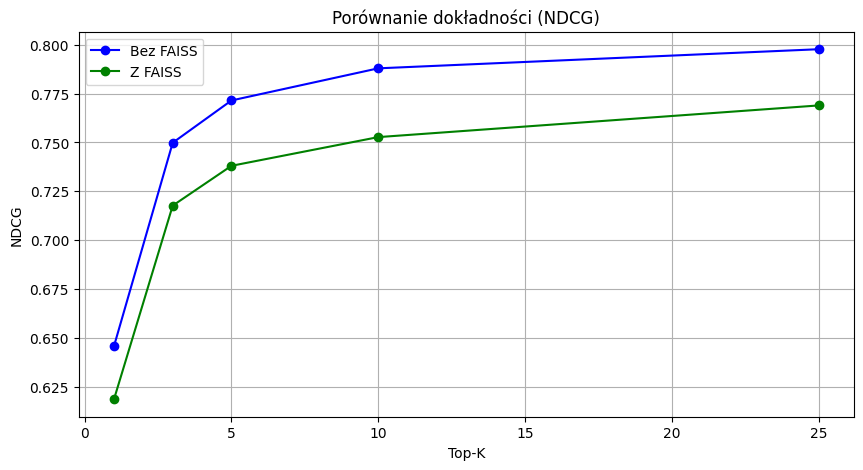

In [ ]:
import matplotlib.pyplot as plt

# Wykres 1: Dokładność (NDCG)
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, ndcg, marker="o", label="Bez FAISS", color="blue")
plt.plot(topk_arr, ndcg_with_faiss, marker="o", label="Z FAISS", color="green")
plt.title("Porównanie dokładności (NDCG)")
plt.xlabel("Top-K")
plt.ylabel("NDCG")
plt.grid(True)
plt.legend()
plt.show()

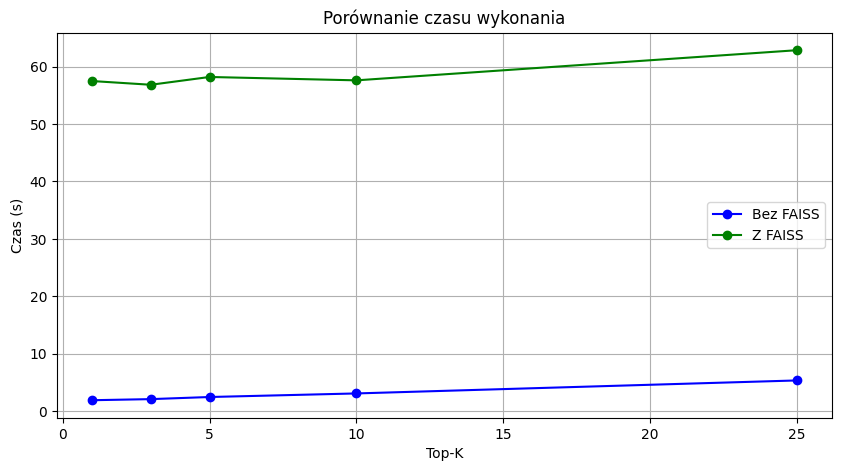

In [ ]:
# Wykres 2: Czas wykonania
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, t, marker="o", label="Bez FAISS", color="blue")
plt.plot(topk_arr, t_with_faiss, marker="o", label="Z FAISS", color="green")
plt.title("Porównanie czasu wykonania")
plt.xlabel("Top-K")
plt.ylabel("Czas (s)")
plt.grid(True)
plt.legend()
plt.show()

## Analiza modelu re-ranker (cross-enkoder)

In [ ]:
# Przygotowanie par (query, answer) do re-rankingu korzystając z all results

all_results_25 = find_similar_sentences(
    question_embeddings=question_embeddings,
    answer_embeddings=answer_embeddings,
    unique_questions=unique_questions,
    unique_answers=unique_answers,
    model=model,
    top_k=25,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
)


pairs = []
for query, answers in all_results_25.items():
    for answer in answers:
        pairs.append((query, answer["answer"]))

In [32]:
len(pairs)

2183525

In [33]:
from sentence_transformers import CrossEncoder

re_ranker = CrossEncoder("cross-encoder/ms-marco-TinyBERT-L-2-v2", device=device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
# Re-ranking za pomocą Cross-Encodera

scores = re_ranker.predict(
    pairs, batch_size=256, show_progress_bar=True, convert_to_tensor=True
)

Batches:   0%|          | 0/8530 [00:00<?, ?it/s]

In [ ]:
# with open('scores25.pkl', 'wb') as f:
#    pickle.dump(scores, f)
#
# with open('re_ranker25.pkl', 'wb') as f:
#    pickle.dump(re_ranker, f)

In [ ]:
import pickle

with open("scores25.pkl", "rb") as f:
    scores = pickle.load(f)

In [ ]:
top_k = 25


def get_ranked_results(scores, pairs, top_k, unique_questions):

    # Tworzenie posortowanych wyników
    ranked_results = {}
    index = 0
    for query in unique_questions:
        ranked_results[query] = []
        for _ in range(top_k):
            if index < len(scores):
                ranked_results[query].append(
                    {"answer": pairs[index][1], "score": scores[index]}
                )
                index += 1
        ranked_results[query] = sorted(
            ranked_results[query], key=lambda x: x["score"], reverse=True
        )

    return ranked_results


rerank_results = get_ranked_results(scores, pairs, top_k, unique_questions)

In [38]:
# Wyświetlenie wyników przed i po re-rankingu
for query in list(all_results.keys())[15:20]:  # Wyświetl dla pierwszych 3 zapytań
    print(f"\nZapytanie: {query}")
    print("Przed re-rankiem:")
    for result in all_results[query][:5]:
        print(f"Score: {result['score']:.2f}, Answer: {result['answer']}")

    print("\nPo re-rankingu:")
    for result in rerank_results[query][:5]:
        print(f"Score: {result['score']:.2f}, Answer: {result['answer']}")


Zapytanie: what parts of algae are unique to them?
Przed re-rankiem:
Score: 0.63, Answer: The algae are a polyphyletic group and are placed in various divisions, some more closely related to plants than others. There are many differences between them in features such as cell wall composition, biochemistry, pigmentation, chloroplast structure and nutrient reserves. The algal division Charophyta, sister to the green algal division Chlorophyta, is considered to contain the ancestor of true plants. The Charophyte class Charophyceae and the land plant sub-kingdom Embryophyta together form the monophyletic group or clade Streptophytina.
Score: 0.61, Answer: Plants and various other groups of photosynthetic eukaryotes collectively known as "algae" have unique organelles known as chloroplasts. Chloroplasts are thought to be descended from cyanobacteria that formed endosymbiotic relationships with ancient plant and algal ancestors. Chloroplasts and cyanobacteria contain the blue-green pigment 

In [ ]:
avg_ndcg = evaluate_results_with_ndcg(
    all_results=rerank_results, true_relevance_dict=true_relevance_dict, top_k=5
)


Średnie NDCG@5: 0.8322


In [ ]:
import time

topk_arr = [1, 3, 5, 10]
ndcg2 = []
ndcg_with_rerank = []

for k in topk_arr:
    all_results_temp = find_similar_sentences(
        question_embeddings=question_embeddings,
        answer_embeddings=answer_embeddings,
        unique_questions=unique_questions,
        unique_answers=unique_answers,
        model=model,
        top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
        n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
    )

    avg_ndcg = evaluate_results_with_ndcg(
        all_results=all_results_temp,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    ndcg2.append(avg_ndcg)

    avg_ndcg_with_rerank = evaluate_results_with_ndcg(
        all_results=rerank_results,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    ndcg_with_rerank.append(avg_ndcg_with_rerank)


Średnie NDCG@1: 0.6459

Średnie NDCG@1: 0.7400

Średnie NDCG@3: 0.7499

Średnie NDCG@3: 0.8172

Średnie NDCG@5: 0.7715

Średnie NDCG@5: 0.8322

Średnie NDCG@10: 0.7879

Średnie NDCG@10: 0.8430


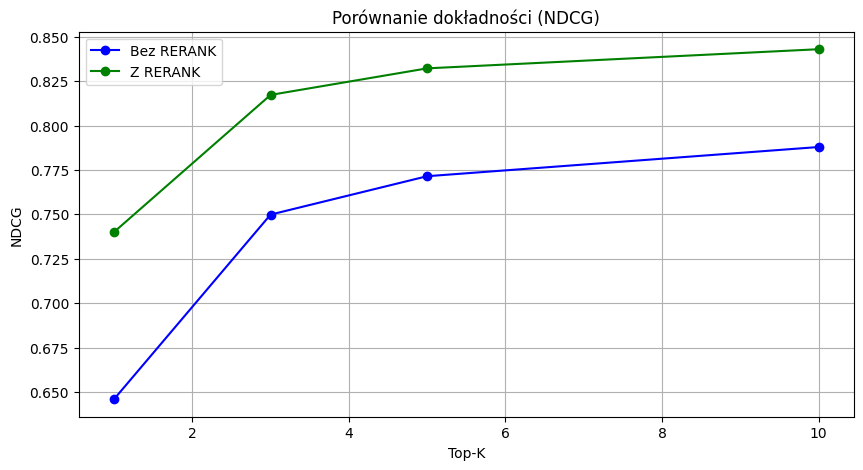

In [ ]:
import matplotlib.pyplot as plt

# Wykres 1: Dokładność (NDCG)
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, ndcg2, marker="o", label="Bez RERANK", color="blue")
plt.plot(topk_arr, ndcg_with_rerank, marker="o", label="Z RERANK", color="green")
plt.title("Porównanie dokładności (NDCG)")
plt.xlabel("Top-K")
plt.ylabel("NDCG")
plt.grid(True)
plt.legend()
plt.show()